In [33]:
import json
import numpy as np
from pancreas import *
from odeclass import *
import matplotlib.pyplot as plt

In [108]:
def MVP(self, d = 0, uI = 0, uP = 0):
    """
    Solves dx = f(x, u, d)

    Parameters
    ----------
    u : int or float 
        Insulin injection rate.
    d : int or float 
        Meal ingestion rate.
    
    Returns
    -------
    dx : numpy array
        Solution to system of differential equations. 
    """
    dD1 = d - self.D1/self.taum
    dD2 = (self.D1 - self.D2)/self.taum
    dIsc = uI/(self.tau1 * self.C1) - self.Isc/self.tau1
    dIp = (self.Isc - self.Ip)/self.tau2 + uP/self.C1
    dIeff = -self.p2 * self.Ieff + self.p2 * self.S1 * self.Ip
    dG = -1*(self.gezi + self.Ieff) * self.G + self.egp0 + 55.5 * self.D2 / (self.Vg * self.taum)
    dGsc = (self.G - self.Gsc) / self.timestep

    dx = np.array([dD1, dD2, dIsc, dIp, dIeff, dG, dGsc])
    return dx


def EHM(self, d = 0, uI = 0, uP = 0, HR = None):
    """
    Solves dx = f(x, u, d)

    Parameters
    ----------
    u : int or float 
        Insulin injection rate.
    d : int or float 
        Meal ingestion rate.
    
    Returns
    -------
    dx : numpy array
        Solution to system of differential equations. 
    """
    G = self.Q1/self.VG
    RA = self.f*self.D2/self.TauD
    D = 1000 * d/self.MwG

    if HR is None:
        HRmax = 220 - self.age
        HR = self.HRR * (HRmax - self.HR0) + self.HR0
    fE1x = (self.E1/(self.a * self.HR0))**self.n
    fE1 = fE1x/(1+fE1x)
    F01c = min(self.F01, self.F01 * G / 4.5)
    FR = max(0.003 * (G - 9) * self.VG, 0) 

    dx = []
    dx.append((G - self.G)/self.TauIG)
    dx.append(-F01c - FR - self.x1 * self.Q1 + self.k12 * self.Q2 + RA + self.EGP0 * (1 - self.x3) \
        + self.Kglu * self.VG * self.Z2 - self.alpha * self.E2**2 * self.x1 * self.Q1)
    dx.append(self.x1 * self.Q1 - (self.k12 + self.x2) * self.Q2 + self.alpha * self.E2**2 * self.x1 * self.Q1 \
        - self.alpha * self.E2**2 * self.x2 * self.Q2 - self.beta * self.E1 / self.HR0)

    dx.append(uI - self.S1 / self.TauS)
    dx.append((self.S1 - self.S2)/self.TauS)
    dx.append(uP / self.VI + self.S2 / (self.VI * self.TauS) - self.ke * self.I) # Den her kan være wack
    dx.append(self.kb1 * self.I - self.ka1 * self.x1)
    dx.append(self.kb2 * self.I - self.ka2 * self.x2)
    dx.append(self.kb3 * self.I - self.ka3 * self.x3)
    dx.append(self.AG * D - self.D1 / self.TauD)
    dx.append((self.D1 - self.D2)/self.TauD)
    dx.append(- self.Z1 / self.Tauglu)
    dx.append((self.Z1 - self.Z2)/self.Tauglu)
    dx.append((HR - self.HR0 - self.E1)/self.TauHR)
    dx.append(-(fE1/self.Tauin - 1/self.TE) * self.E2 + fE1 * self.TE /(self.c1 + self.c2))
    dx.append((self.c1 * fE1 + self.c2 - self.TE)/self.Tauex)
    return np.array(dx)

In [33]:
class patient(ODE):
    def __init__(self, model = "EHM",**kwargs):
        self.model = model.upper()
        self.pancreas_model = pancreas_model.upper()

        defaults = {}
        with open('config.json', 'r') as f:
            data = json.load(f)
        defaults.update(data["general"])
        defaults.update(data[self.model])
        defaults.update(kwargs) 

        super().__init__(defaults) # initialises patient object with attributes and methods of ODE class

        # sets function to compute derivative of state
        if self.model == "EHM":
            self.f_func = lambda **kwargs : EHM(self, **kwargs)
        if self.model == "MVP":
            self.f_func = lambda **kwargs : MVP(self, **kwargs)
            


In [8]:
import numpy as np
np.array([[3]]).flatten()

array([3])

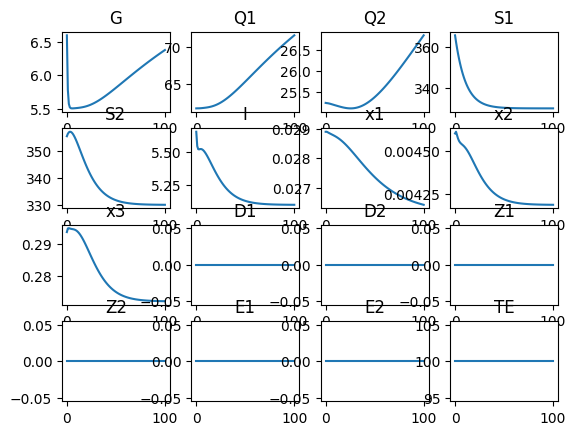

In [143]:
def MVP(self, d = 0, uI = 0, uP = 0):
    """
    Solves dx = f(x, u, d)

    Parameters
    ----------
    u : int or float 
        Insulin injection rate.
    d : int or float 
        Meal ingestion rate.
    
    Returns
    -------
    dx : numpy array
        Solution to system of differential equations. 
    """
    dD1 = d - self.D1/self.taum
    dD2 = (self.D1 - self.D2)/self.taum
    dIsc = uI/(self.tau1 * self.C1) - self.Isc/self.tau1
    dIp = (self.Isc - self.Ip)/self.tau2
    dIeff = -self.p2 * self.Ieff + self.p2 * self.S1 * self.Ip
    dG = -1*(self.gezi + self.Ieff) * self.G + self.egp0 + 55.5 * self.D2 / (self.Vg * self.taum)
    dGsc = (self.G - self.Gsc) / self.timestep

    dx = np.array([dD1, dD2, dIsc, dIp, dIeff, dG, dGsc])
    return dx


def EHM(self, d = 0, uI = 0, uP = 0, HR = None):
    """
    Solves dx = f(x, u, d)

    Parameters
    ----------
    u : int or float 
        Insulin injection rate.
    d : int or float 
        Meal ingestion rate.
    
    Returns
    -------
    dx : numpy array
        Solution to system of differential equations. 
    """
    G = self.Q1/(self.VG * self.BW)
    RA = self.f*self.D2/self.TauD
    D = 1000 * d/self.MwG
    if HR is None:
        HRmax = 220 - self.age
        HR = self.HRR * (HRmax - self.HR0) + self.HR0
    fE1x = (self.E1/(self.a * self.HR0))**self.n
    fE1 = fE1x/(1+fE1x)
    F01c = min(self.F01, self.F01 * G / 4.5) * self.BW
    FR = max(0.003 * (G - 9) * self.VG * self.BW, 0) 

    dx = []
    dx.append((G - self.G)/self.TauIG)
    dx.append(-F01c - FR - self.x1 * self.Q1 + self.k12 * self.Q2 + RA + self.BW * self.EGP0 * (1 - self.x3) \
        + self.Kglu * self.VG * self.Z2 - self.alpha * self.E2**2 * self.x1 * self.Q1)
    dx.append(self.x1 * self.Q1 - (self.k12 + self.x2) * self.Q2 + self.alpha * self.E2**2 * self.x1 * self.Q1 \
        - self.alpha * self.E2**2 * self.x2 * self.Q2 - self.beta * self.E1 / self.HR0)

    dx.append(uI - self.S1 / self.TauS)
    dx.append((self.S1 - self.S2)/self.TauS)
    dx.append(uP / self.VI * self.BW + self.S2 / (self.VI * self.BW * self.TauS) - self.ke * self.I) # Den her kan være wack
    dx.append(self.kb1 * self.I - self.ka1 * self.x1)
    dx.append(self.kb2 * self.I - self.ka2 * self.x2)
    dx.append(self.kb3 * self.I - self.ka3 * self.x3)
    dx.append(self.AG * D - self.D1 / self.TauD)
    dx.append((self.D1 - self.D2)/self.TauD)
    dx.append(- self.Z1 / self.Tauglu)
    dx.append((self.Z1 - self.Z2)/self.Tauglu)
    dx.append((HR - self.HR0 - self.E1)/self.TauHR)
    dx.append(-(fE1/self.Tauin - 1/self.TE) * self.E2 + fE1 * self.TE /(self.c1 + self.c2))
    dx.append((self.c1 * fE1 + self.c2 - self.TE)/self.Tauex)
    return np.array(dx)

class Patient(ODE):
    def __init__(self, patient_type, model = "EHM", **kwargs):
        self.model = model.upper()
        
        defaults = {} #tomt dictionary 
        with open('config.json', 'r') as f:
            data = json.load(f) #læs json-fil
        defaults.update(data["general"]) #tilføj "general" til dictionary(defaults)
        defaults.update(data[self.model]) #tilføj modelegenskaberne til dictionary(defaults)
        defaults.update(kwargs) #tilføj keywordarguments til dictionary(defaults)

        super().__init__(defaults)
        if self.model == "MVP":
            self.f_func = lambda **kwargs: MVP(self,**kwargs) #caller MVP-modellen
        else:
            self.f_func = lambda **kwargs: EHM(self,**kwargs) #caller EHM-modellen

        if patient_type != 1:
            self.pancreasObj = PKPM(timestep=self.timestep, Gbar=self.Gbar)
        if patient_type != 0:
            self.pumpObj = PID(Kp = self.Kp, Td = self.Td, Ti = self.Ti, ybar = self.Gbar, timestep=self.timestep)
            
        if patient_type == 0:
            self.pancreas = lambda G : self.pancreasObj.eval(G)
            self.pump = lambda G : 0
        if patient_type == 1:
            self.pancreas = lambda G : 0
            self.pump = lambda G : max(self.pumpObj.eval(G) + self.us,0)
        if patient_type == 2:
            self.pancreas = lambda G : self.W * self.pancreasObj(G)
            self.pump = lambda G : max(self.pumpObj.eval(G) + self.us,0)
        
        

    def glucose_penalty(self, G = None):
        """
        Calculates penalty given blood glucose.
        p = 1/2 (G - Gbar)**2 + kappa/2 * max(Gmin - G, 0)**2

        Parameters
        ----------
        Gbar : int or float 
            Desired blood glucose
        kappa : int or float 
            Penalty weight
        Gmin : int or float
            Threshold for hypoglycemia
        G : int, float, np.ndarray, list, default: None
            Glucose to evaluate penalty for. If not set, use current state.
        
        Returns
        -------
        p(G) : float
            Penalty
        """
        if G is None: # If G is not specified, use current G
            G = self.G
        func = lambda g :  1/2 * (g - self.Gbar)**2 + self.kappa/2 * max((self.Gmin - g), 0)**2
        if isinstance(G, (np.ndarray, list)):
            return np.array([func(Gi) for Gi in G])
        return func(G)
 
    def bolus_sim(self, bolus, meal_size, meal_idx = 0, iterations = 100, plot = False):
        ds = np.zeros(iterations)
        us = np.ones(iterations) * self.us
        ds[meal_idx] = meal_size / self.timestep # Ingestion 
        us[0] += bolus * 1000 / self.timestep
        states, _ = self.simulate(ds, us)
        Gt = self.get_attr(states, "G")
        p = self.glucose_penalty(Gt)
        t = self.time_arr(iterations + 1)/60
        phi = simpson(p, x = t)
        if plot:
            fig, ax = plt.subplots(1,2)
            ax[0].plot(t, p)
            ax[1].plot(t, Gt)
            ax[0].set_xlabel("time(h)")
            ax[1].set_xlabel("time(h)")
            ax[1].set_ylabel("g")

            ax[0].set_title("Penalty Function")
            ax[1].set_title("Blood Glucose")
            plt.show()
        return phi, p, Gt

    def simulate(self, ds, HR = None):
        """
        Simulates patient.

        Parameters
        ----------
        ds : numpy array
            Ingestion rate
        u_func : Default = None, int, float, numpy array, list or "PID"
            Specifies insulin injection rate.
            If None; uses steady state insulin rate.
            If "PID"; uses PID controller.
        
        Returns
        -------
        states : numpy array
            State vector in each time step
        u_list : numpy array
            Insulin injection rate for each time step
        """
        info = dict()
        for i in self.state_keys:
            info[i]=np.empty(len(ds)+1)
            info[i][0]=getattr(self,i)
        info["t"] = self.time_arr(len(ds)+1)
        if HR is not None:
            info["HR"] = HR

        info["uP"] = []
        info["uI"] = []
        for i,d in enumerate(ds):
            uP = self.pancreas(self.G)
            uI = self.pump(self.G)
            dx = self.f_func(d = d, uI = uI, uP = uP)
            self.euler_step(dx)     

            for k in self.state_keys:
                info[k][i+1]=getattr(self,k)
            info["uP"].append(uP)
            info["uI"].append(uI)

     #   info["pens"]=self.glucose_penalty(info["G"])
        return info
p = Patient(1, "EHM")
p.pumpObj.Kp = 0
p.us = 6
info = p.simulate(np.zeros(100))
fig, ax = plt.subplots(4,4)
for i,k in enumerate(p.state_keys):
    ax[i//4, i%4].set_title(k)
    ax[i//4, i%4].plot(info[k])

In [81]:
1000/18.018

55.500055500055495

In [37]:
18.018*6

108.108

In [35]:
class TD1:
    def __init__(self, model ="EHM", **kwargs):
        self.model = model.upper()
        
        defaults = {} #tomt dictionary 
        with open('config.json', 'r') as f:
            data = json.load(f) #læs json-fil
        defaults.updata(data["general"]) #tilføj "general" til dictionary(defaults)
        defaults.update(data[self.model]) #tilføj modelegenskaberne til dictionary(defaults)
        defaults.update(kwargs) #tilføj keywordarguments til dictionary(defaults)

        if self.model == "MVP":
            self.f_func = lambda *args: MVP(self,*args) #caller MVP-modellen
        else:
            self.f_func = lambda *args: EHM(self,*args) #caller EHM-modellen

    def PID_controller(self, I, y, y_prev):
        """
        :input I: Integral term
        :input Gbar: Glucose concentration target
        :input y: Current blood glucose
        :input y_prev: Previous blood glucose
        :input us: Insulin steady state
        Tuning parameters
        :input Kp: Range 0-0.5
        :input Ti: 100-1000 minutes
        :input Td : 0-30 min
        """
        ek = y - self.Gbar
        Pk = self.Kp * ek
        Ki = self.Kp * self.timestep / self.Ti
        Ikp1 = I + Ki * ek
        Kd = self.Kp * self.Td / self.timestep
        Dk = Kd * (y - y_prev)
        uk = self.us + Pk + I + Dk
        uk = max(uk, 0)
        
        return uk, Ikp1


In [36]:
class TD2:
    def __init__(self, model ="EHM", **kwargs):
        self.model = model.upper()
        
        defaults = {} #tomt dictionary 
        with open('config.json', 'r') as f:
            data = json.load(f) #læs json-fil
        defaults.updata(data["general"]) #tilføj "general" til dictionary(defaults)
        defaults.update(data[self.model]) #tilføj modelegenskaberne til dictionary(defaults)
        defaults.update(kwargs) #tilføj keywordarguments til dictionary(defaults)

        if self.model == "MVP":
            self.f_func = lambda *args: MVP(self,*args) #caller MVP-modellen
        else:
            self.f_func = lambda *args: EHM(self,*args) #caller EHM-modellen

    def PID_controller(self, I, y, y_prev):
        """
        :input I: Integral term
        :input Gbar: Glucose concentration target
        :input y: Current blood glucose
        :input y_prev: Previous blood glucose
        :input us: Insulin steady state
        Tuning parameters
        :input Kp: Range 0-0.5
        :input Ti: 100-1000 minutes
        :input Td : 0-30 min
        """
        ek = y - self.Gbar
        Pk = self.Kp * ek
        Ki = self.Kp * self.timestep / self.Ti
        Ikp1 = I + Ki * ek
        Kd = self.Kp * self.Td / self.timestep
        Dk = Kd * (y - y_prev)
        uk = self.us + Pk + I + Dk
        uk = max(uk, 0)
        
        return uk, Ikp1
    
